In [16]:
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
from sympy import *
from tqdm import tqdm_notebook
import pyemma

In [17]:
# Symbols
x = symbols('x')
m = symbols('mu')
s = symbols('sigma')

# Potential
U = -log(exp(-(x-m)**2/(2*s**2)) + exp(-(x+m)**2/(2*s**2)))

# Brownian Dynamics Parameters
KT = symbols('k_{B}T')
Ddt = symbols('Ddt')
R = symbols('R')

# Other Parameters
steps = 1000
dt = 0.01

# Forces
F1 = simplify(-diff(U, x))*Ddt/KT
F2 = sqrt(2*Ddt)*R
F = F1 + F2

In [3]:
def sim(m_val):
    # Substitute Actuall Values into F
    F_val = F.subs(m, m_val).subs(s, 1).subs(KT, 1).subs(Ddt, 0.01)
    
    # Time array
    ts = np.arange(0, steps, dt)
    
    # Positions array
    xs = np.zeros(ts.shape[0])
    
    # Randomness array
    rs = np.random.normal(0, 1, size=ts.shape[0])
    
    # Simulation
    for i, t in enumerate(tqdm_notebook(ts)):
        xs[i] = xs[i-1] + F_val.subs(x, xs[i-1]).subs(R, rs[i]).evalf()
    return xs

In [30]:
def kramers(U, M, S, dt):
    U_ = U.subs(m, M).subs(s, S)
    U0 = U_.subs(x, 0)
    Um = U_.subs(x, M)
    dE = U0-Um
    U_1 = diff(U, x)
    U_2 = diff(U_1, x)
    Wa = sqrt(U_2.subs(x, M).subs(m, M).subs(s, S))
    Wb = sqrt(abs(U_2.subs(x, 0).subs(m, M).subs(s, S)))
    k = 2*pi/(Wa*Wb*dt)*exp(dE)
    return k.evalf()

In [ ]:
Ms = np.arange(1.5, 3.5, 0.5)
means = np.zeros(Ms.shape[0])
for i, m_val in enumerate(Ms):
    data = sim(m_val)
    cluster_centers = np.array([[-m_val],[m_val]])
    cluster_dtrajs = pyemma.coordinates.assign_to_centers(data, cluster_centers)
    its = pyemma.msm.its(cluster_dtrajs, lags=np.linspace(1, 5000, 20).astype(int), nits=1, errors='bayes')
    LAG = 600
    bayesian_msm = pyemma.msm.bayesian_markov_model(cluster_dtrajs, lag=LAG, conf=0.95)
    sample_mean = bayesian_msm.sample_mean('timescales', k=1)
    means[i] = sample_mean

In [14]:
with open('../data/kr_all.data', 'r') as f:
    means = np.loadtxt(f)

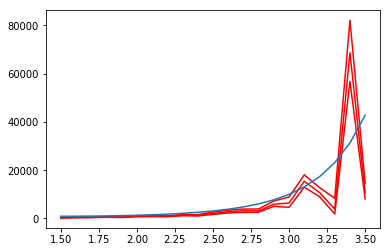

In [48]:
ms = means[:,0]
ks = np.array([kramers(U, mm, 1, 0.01) for mm in ms])
plt.plot(ms, means[:,1:], 'red')
plt.plot(ms, ks)